In [2]:
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
import tetrion.plots as plots
import tetrion.db
import tetrion.commands as cmd
import tetrion.options
import tetrion.clientcore
import seaborn as sns
from collections import defaultdict
import numpy as np
import warnings
import matplotlib.pyplot as plt
warnings.simplefilter("ignore")
%matplotlib inline 
symbol = pd.read_csv('/local/dist/tetrion/conf/conf/symbol.table', skiprows= 1, header = 2,  delim_whitespace=True)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)
# import sys
# sys.path.append('../utils')  # Adjust the path to where the eventstudy module is located
# import eventstudy as es
import pandas as pd
import warnings
from tqdm import tqdm
import os

In [3]:
def load_parquet_date_range(kind, instr, start_date, end_date, base_path="data/cache"):
    date_range = pd.date_range(start=start_date, end=end_date, freq='D')
    dfs = []

    for date in date_range:
        date_str = date.strftime("%Y%m%d")
        path = f"{base_path}/{kind}/{instr}/{date_str}.parquet"
        if os.path.exists(path):
            df = pd.read_parquet(path)
            dfs.append(df)
        else:
            print(f"檔案缺少：{path}")

    if dfs:
        return pd.concat(dfs).sort_index()
    else:
        raise ValueError("沒有成功讀取任何檔案")

# 使用範例（讀入多日 ticks）
txf_ticks = load_parquet_date_range("tick", "TXF", "2025-04-25", "2025-05-06")
txf_books = load_parquet_date_range("book", "TXF", "2025-04-25", "2025-05-06")


檔案缺少：data/cache/tick/TXF/20250427.parquet
檔案缺少：data/cache/tick/TXF/20250504.parquet
檔案缺少：data/cache/book/TXF/20250427.parquet
檔案缺少：data/cache/book/TXF/20250504.parquet


In [4]:
txf_ticks

,ex_time,instr,sz,px,bid_px,ask_px,bid_sz,ask_sz
time,,,,,,,,
2025-04-25 00:00:00.184783,2025-04-25 00:00:00.080,FUT_TAIFEX_TXF:202505,1,19777.0,19775.0,19778.0,6,4
2025-04-25 00:00:00.559778,2025-04-25 00:00:00.488,FUT_TAIFEX_TXF:202505,1,19779.0,19777.0,19779.0,3,3
2025-04-25 00:00:00.559778,2025-04-25 00:00:00.488,FUT_TAIFEX_TXF:202505,1,19780.0,19777.0,19779.0,3,3
2025-04-25 00:00:00.809766,2025-04-25 00:00:00.723,FUT_TAIFEX_TXF:202505,6,19780.0,19777.0,19780.0,7,6
2025-04-25 00:00:01.059653,2025-04-25 00:00:00.986,FUT_TAIFEX_TXF:202505,1,19781.0,19778.0,19781.0,6,5
...,...,...,...,...,...,...,...,...
2025-05-06 23:59:57.434721,2025-05-06 23:59:57.368,FUT_TAIFEX_TXF:202505,1,20312.0,20311.0,20312.0,2,4
2025-05-06 23:59:57.434743,2025-05-06 23:59:57.368,FUT_TAIFEX_TXF:202505,1,20312.0,20311.0,20312.0,2,4
2025-05-06 23:59:57.934728,2025-05-06 23:59:57.898,FUT_TAIFEX_TXF:202505,1,20311.0,20311.0,20313.0,2,14


In [5]:
ticks_for_analysis = txf_ticks.copy()
ticks_for_analysis['ex_time'] = pd.to_datetime(ticks_for_analysis['ex_time'])
ticks_for_analysis = ticks_for_analysis.rename(columns={'ex_time': 'time'}).set_index('time')


In [6]:
merged_df = pd.merge(ticks_for_analysis[['sz','px']], txf_books, on='time', how='outer', sort=True)
merged_df['sz'] = merged_df['sz'].fillna(0)

merged_df[txf_books.columns] = merged_df[txf_books.columns].ffill()

In [7]:
traded = merged_df[merged_df['sz'] != 0].copy()

# 定義穿價條件（避免 ask_px4 或 bid_px4 為 0）
up_cross = (traded['ask_px2'] != 0) & (traded['px'] > traded['ask_px2'])
down_cross = (traded['bid_px2'] != 0) & (traded['px'] < traded['bid_px2'])

# 建立穿價標籤
traded['trade_through'] = 'none'
traded.loc[up_cross, 'trade_through'] = 'upward'
traded.loc[down_cross, 'trade_through'] = 'downward'


# 只留下有穿價的成交
trade_through_df = traded[traded['trade_through'] != 'none']

In [8]:
import sys
import os
sys.path.append(os.path.abspath(".."))
from eddie_tools.record import RedisFillLoader

In [9]:
tmf = RedisFillLoader('2025,4,25','2025,5,8','capital_electron_tmf')

In [10]:
df = tmf.load_concat_df()
fills_df = df[df['instr'].str.contains('tmf:202505', case=False, na=False)]

Concatenating fills: 100%|██████████| 14/14 [00:00<00:00, 16.13it/s]


In [11]:
def match_fills_to_trade_through(fills_df, trade_through_df, threshold_seconds=0.1):
    import pandas as pd

    fills_df = fills_df.copy()
    trade_through_df = trade_through_df.copy()

    # 確保 time 是欄位，不是 index
    if fills_df.index.name == 'time' or 'time' not in fills_df.columns:
        fills_df = fills_df.reset_index()

    if trade_through_df.index.name == 'time' or 'time' not in trade_through_df.columns:
        trade_through_df = trade_through_df.reset_index()

    fills_df = fills_df.sort_values("time")
    trade_through_df = trade_through_df.sort_values("time")

    if 'trade_through' not in trade_through_df.columns:
        raise ValueError("`trade_through_df` must contain 'trade_through' column")

    trade_through_df = trade_through_df[['time', 'trade_through']]

    # merge_asof 按時間對應最近穿價事件
    merged = pd.merge_asof(
        fills_df,
        trade_through_df,
        on='time',
        direction='backward',
        tolerance=pd.Timedelta(seconds=threshold_seconds)
    )

    merged["is_trade_near_cross"] = merged["trade_through"].notna()
    return merged


In [12]:
def analyze_ratio_count_and_volume(df):
    df = df.copy()
    df['trade_through'] = df['trade_through'].fillna('no-through')

    for label, sub_df in [('long', df[df['sz'] > 0]), ('short', df[df['sz'] < 0])]:
        total_count = len(sub_df)
        total_volume = sub_df['sz'].abs().sum()

        if total_count == 0 or total_volume == 0:
            print(f"\n沒有 {label.upper()} TMF")
            continue

        ratio_count = sub_df['trade_through'].value_counts(normalize=True)
        ratio_volume = sub_df.groupby('trade_through')['sz'].apply(lambda x: x.abs().sum()) / total_volume

        print(f"\nElectron {label.upper()} 202505TMF 時 :")
        print(f"使用成交口數加權-> TXF 價格上穿: {ratio_volume.get('upward', 0):.2%}, TXF 價格下穿: {ratio_volume.get('downward', 0):.2%}, 無穿價: {ratio_volume.get('no-through', 0):.2%}")


In [13]:
merged_fills = match_fills_to_trade_through(fills_df, trade_through_df, threshold_seconds=0.01)

In [14]:
analyze_ratio_count_and_volume(merged_fills)


Electron LONG 202505TMF 時 :
使用成交口數加權-> TXF 價格上穿: 19.23%, TXF 價格下穿: 8.16%, 無穿價: 72.61%

Electron SHORT 202505TMF 時 :
使用成交口數加權-> TXF 價格上穿: 10.23%, TXF 價格下穿: 37.04%, 無穿價: 52.74%


In [15]:
merged_fills_night = merged_fills.set_index('time').between_time('15:00:00','05:00:00')

In [16]:
analyze_ratio_count_and_volume(merged_fills_night)


Electron LONG 202505TMF 時 :
使用成交口數加權-> TXF 價格上穿: 16.48%, TXF 價格下穿: 8.70%, 無穿價: 74.82%

Electron SHORT 202505TMF 時 :
使用成交口數加權-> TXF 價格上穿: 11.78%, TXF 價格下穿: 40.80%, 無穿價: 47.42%


* 使用加權的原因：原本計算方式不太合理 會使short 1口 TMF以及 short 20口 tmf擁有相同比重 因此使用sz加權算機率較合邏輯

In [17]:
merged_fills_night

,ts,instr,oflag,tid,px,alqortake,sz,theo,fwd,ffwd,edge,roll_offset,label,delta,vega,gamma,theta,vol,mult,latefill,fee,qm,pfdelta,otags,seq,trade_through,is_trade_near_cross
time,,,,,,,,,,,,,,,,,,,,,,,,,,,
2025-04-24 19:39:07.756836,1745494747756836,FUT_TAIFEX_TMF:202505,0,TAIFEX155#290618,19520,alq,1,19521.0,19521.0,19521,0,0,,1,0,0,0,0,10,False,1.19040,0,0,0x20000,23,NaN,False
2025-04-24 19:39:07.938710,1745494747938710,FUT_TAIFEX_TMF:202505,0,TAIFEX155#290659,19523,take,20,19522.5,19522.5,19522.5,0,0,,1,0,0,0,0,10,True,1.19046,0,0,0x20000,24,NaN,False
2025-04-24 19:39:07.939160,1745494747939160,FUT_TAIFEX_TMF:202505,0,TAIFEX155#290661,19524,take,5,19524.5,19524.5,19524.5,0,0,,1,0,0,0,0,10,False,1.19048,0,0,0x0,26,NaN,False
2025-04-24 19:39:07.939194,1745494747939194,FUT_TAIFEX_TMF:202505,0,TAIFEX155#290661,19525,take,15,19524.5,19524.5,19524.5,0,0,,1,0,0,0,0,10,False,1.19050,0,0,0x0,27,NaN,False
2025-04-24 19:39:07.946233,1745494747946233,FUT_TAIFEX_TMF:202505,0,TAIFEX155#290668,19525,alq,-1,19524.5,19524.5,19524.5,0,0,,1,0,0,0,0,10,False,1.19050,0,0,0x20000,29,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-08 04:59:33.838739,1746651573838739,FUT_TAIFEX_TMF:202505,0,TAIFEX155#997839,20519,take,-1,20518.5,20518.5,20518.5,0,0,,1,0,0,0,0,10,False,1.21038,0,0,0x0,262,NaN,False
2025-05-08 04:59:33.838796,1746651573838796,FUT_TAIFEX_TMF:202505,0,TAIFEX155#997839,20515,take,-5,0.0,0.0,NaN,0,0,,1,0,0,0,0,10,False,1.21030,0,0,0x0,266,NaN,False
2025-05-08 04:59:33.838796,1746651573838796,FUT_TAIFEX_TMF:202505,0,TAIFEX155#997839,20516,take,-7,20515.5,20515.5,20515.5,0,0,,1,0,0,0,0,10,False,1.21032,0,0,0x0,265,NaN,False


In [18]:
import numpy as np

def analyze_ratio_count_and_volume2(df):
    df = df.copy()
    df['trade_through'] = df['trade_through'].fillna('no-through')

    for label, sub_df in [('long', df[df['sz'] > 0]), ('short', df[df['sz'] < 0])]:
        if sub_df.empty:
            print(f"\n沒有 {label.upper()} TMF")
            continue

        # 成交量加權機率
        weights = sub_df['sz'].abs()

        # 先轉成 one-hot 類型欄位
        upward = (sub_df['trade_through'] == 'upward').astype(int)
        downward = (sub_df['trade_through'] == 'downward').astype(int)
        no_through = (sub_df['trade_through'] == 'no-through').astype(int)

        # 加權平均
        weighted_upward = np.average(upward, weights=weights)
        weighted_downward = np.average(downward, weights=weights)
        weighted_no_through = np.average(no_through, weights=weights)

        
        ratio_count = sub_df['trade_through'].value_counts(normalize=True)

        print(f"\nElectron {label.upper()} 202505TMF 時:")
        print(f"只看成交次數比率 -> 上穿: {ratio_count.get('upward', 0):.2%}, 下穿: {ratio_count.get('downward', 0):.2%}, 無穿價: {ratio_count.get('no-through', 0):.2%}")
        print(f"成交口數加權機率 -> 上穿: {weighted_upward:.2%}, 下穿: {weighted_downward:.2%}, 無穿價: {weighted_no_through:.2%}")


In [19]:
analyze_ratio_count_and_volume2(merged_fills_night)


Electron LONG 202505TMF 時:
只看成交次數比率 -> 上穿: 10.28%, 下穿: 5.87%, 無穿價: 83.85%
成交口數加權機率 -> 上穿: 16.48%, 下穿: 8.70%, 無穿價: 74.82%

Electron SHORT 202505TMF 時:
只看成交次數比率 -> 上穿: 4.95%, 下穿: 26.50%, 無穿價: 68.55%
成交口數加權機率 -> 上穿: 11.78%, 下穿: 40.80%, 無穿價: 47.42%


* old version group by second

In [20]:
# def group_fills_within_seconds(fills_df, threshold_seconds=1):
#     # df = fills_df.reset_index().sort_values('time').copy()  # <-- 這裡加上 reset_index()
#     df['time'] = pd.to_datetime(df['time'])
#     df['time_diff'] = df['time'].diff().dt.total_seconds().fillna(float('inf'))
#     df['group_id'] = (df['time_diff'] > threshold_seconds).cumsum()

#     grouped = (
#         df.groupby('group_id')
#         .agg(
#             time=('time', 'first'),
#             sz=('sz', 'sum'),
#             px=('px', 'mean'),
#             instr=('instr', 'first')
#         )
#         .reset_index(drop=True)
#     )

#     return grouped


In [21]:
# def match_grouped_fills_to_trade_through(grouped_fills_df, trade_through_df, threshold_seconds=1):
#     import pandas as pd

#     grouped_fills_df = grouped_fills_df.copy()
#     trade_through_df = trade_through_df.copy()

#     # 確保 time 是欄位，不是 index（兩個 df 都做）
#     if grouped_fills_df.index.name == 'time' or 'time' not in grouped_fills_df.columns:
#         grouped_fills_df = grouped_fills_df.reset_index()

#     if trade_through_df.index.name == 'time' or 'time' not in trade_through_df.columns:
#         trade_through_df = trade_through_df.reset_index()

#     grouped_fills_df = grouped_fills_df.sort_values("time")
#     trade_through_df = trade_through_df.sort_values("time")

#     # 確保只有必要欄位，不要有衝突
#     if 'trade_through' not in trade_through_df.columns:
#         raise ValueError("trade_through_df must contain 'trade_through' column")

#     trade_through_df = trade_through_df[["time", "trade_through"]]

#     # merge_asof
#     merged = pd.merge_asof(
#         grouped_fills_df,
#         trade_through_df,
#         on="time",
#         direction="backward",
#         tolerance=pd.Timedelta(seconds=threshold_seconds)
#     )

#     merged["is_trade_near_cross"] = merged["trade_through"].notna()
#     return merged



In [22]:
# grouped_fills = group_fills_within_seconds(fills_df, threshold_seconds=1)
# merged_sec_df = match_grouped_fills_to_trade_through(grouped_fills, trade_through_df, threshold_seconds=1)


In [23]:
# analyze_ratio_count_and_volume(merged_sec_df)

### Neutrino

In [24]:
tmf_ticks = load_parquet_date_range("tick", "TMF", "2025-04-25", "2025-05-06")
tmf_books = load_parquet_date_range("book", "TMF", "2025-04-25", "2025-05-06")

檔案缺少：data/cache/tick/TMF/20250427.parquet
檔案缺少：data/cache/tick/TMF/20250504.parquet
檔案缺少：data/cache/book/TMF/20250427.parquet
檔案缺少：data/cache/book/TMF/20250504.parquet


In [25]:
tmf_ticks_for_analysis = tmf_ticks.copy()
tmf_ticks_for_analysis['ex_time'] = pd.to_datetime(tmf_ticks_for_analysis['ex_time'])
tmf_ticks_for_analysis = tmf_ticks_for_analysis.rename(columns={'ex_time': 'time'}).set_index('time')

In [26]:
merged_df = pd.merge(tmf_ticks_for_analysis[['sz','px']], tmf_books, on='time', how='outer', sort=True)
merged_df['sz'] = merged_df['sz'].fillna(0)

merged_df[tmf_books.columns] = merged_df[tmf_books.columns].ffill()

In [27]:
traded_tmf = merged_df[merged_df['sz'] != 0].copy()

# 定義穿價條件（避免 ask_px4 或 bid_px4 為 0）
up_cross_tmf = (traded_tmf['ask_px2'] != 0) & (traded_tmf['px'] > traded_tmf['ask_px2'])
down_cross_tmf = (traded_tmf['bid_px2'] != 0) & (traded_tmf['px'] < traded_tmf['bid_px2'])

# 建立穿價標籤
traded_tmf['trade_through'] = 'none'
traded_tmf.loc[up_cross_tmf, 'trade_through'] = 'upward'
traded_tmf.loc[down_cross_tmf, 'trade_through'] = 'downward'


# 只留下有穿價的成交
tmf_trade_through_df = traded_tmf[traded_tmf['trade_through'] != 'none']

In [28]:
txf = RedisFillLoader('2025,4,25','2025,5,8','capital_neutrino_txf')

In [29]:
df2 = txf.load_concat_df()
fills_df2 = df2[df2['instr'].str.contains('txf:202505', case=False, na=False)]

Concatenating fills: 100%|██████████| 14/14 [00:00<00:00, 15.82it/s]


In [30]:
merged_fills2 = match_fills_to_trade_through(fills_df2, trade_through_df, threshold_seconds=0.01)

In [31]:
import numpy as np

def analyze_ratio_count_and_volume2(df):
    df = df.copy()
    df['trade_through'] = df['trade_through'].fillna('no-through')

    for label, sub_df in [('long', df[df['sz'] > 0]), ('short', df[df['sz'] < 0])]:
        if sub_df.empty:
            print(f"\n沒有 {label.upper()} TMF")
            continue

        # 成交量加權機率
        weights = sub_df['sz'].abs()

        # 先轉成 one-hot 類型欄位
        upward = (sub_df['trade_through'] == 'upward').astype(int)
        downward = (sub_df['trade_through'] == 'downward').astype(int)
        no_through = (sub_df['trade_through'] == 'no-through').astype(int)

        # 加權平均
        weighted_upward = np.average(upward, weights=weights)
        weighted_downward = np.average(downward, weights=weights)
        weighted_no_through = np.average(no_through, weights=weights)

        
        ratio_count = sub_df['trade_through'].value_counts(normalize=True)

        print(f"Neutrino {label.upper()} TXF:202505 時:")
        print(f"成交口數加權機率 -> 上穿: {weighted_upward:.2%}, 下穿: {weighted_downward:.2%}, 無穿價: {weighted_no_through:.2%}")


In [32]:
analyze_ratio_count_and_volume2(merged_fills2[merged_fills['alqortake'] != 'take'])

Neutrino LONG TXF:202505 時:
成交口數加權機率 -> 上穿: 1.72%, 下穿: 60.34%, 無穿價: 37.93%
Neutrino SHORT TXF:202505 時:
成交口數加權機率 -> 上穿: 44.23%, 下穿: 5.77%, 無穿價: 50.00%


In [33]:
analyze_ratio_count_and_volume(merged_fills[merged_fills['alqortake'] == 'take'])


Electron LONG 202505TMF 時 :
使用成交口數加權-> TXF 價格上穿: 23.74%, TXF 價格下穿: 6.08%, 無穿價: 70.18%

Electron SHORT 202505TMF 時 :
使用成交口數加權-> TXF 價格上穿: 2.18%, TXF 價格下穿: 61.13%, 無穿價: 36.69%


In [34]:
fills_df

,time,ts,instr,oflag,tid,px,alqortake,sz,theo,fwd,ffwd,edge,roll_offset,label,delta,vega,gamma,theta,vol,mult,latefill,fee,qm,pfdelta,otags,seq
0,2025-04-24 19:39:07.756836,1745494747756836,FUT_TAIFEX_TMF:202505,0,TAIFEX155#290618,19520,alq,1,19521.0,19521.0,19521,0,0,,1,0,0,0,0,10,False,1.19040,0,0,0x20000,23
1,2025-04-24 19:39:07.938710,1745494747938710,FUT_TAIFEX_TMF:202505,0,TAIFEX155#290659,19523,take,20,19522.5,19522.5,19522.5,0,0,,1,0,0,0,0,10,True,1.19046,0,0,0x20000,24
3,2025-04-24 19:39:07.939160,1745494747939160,FUT_TAIFEX_TMF:202505,0,TAIFEX155#290661,19524,take,5,19524.5,19524.5,19524.5,0,0,,1,0,0,0,0,10,False,1.19048,0,0,0x0,26
4,2025-04-24 19:39:07.939194,1745494747939194,FUT_TAIFEX_TMF:202505,0,TAIFEX155#290661,19525,take,15,19524.5,19524.5,19524.5,0,0,,1,0,0,0,0,10,False,1.19050,0,0,0x0,27
6,2025-04-24 19:39:07.946233,1745494747946233,FUT_TAIFEX_TMF:202505,0,TAIFEX155#290668,19525,alq,-1,19524.5,19524.5,19524.5,0,0,,1,0,0,0,0,10,False,1.19050,0,0,0x20000,29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1506,2025-05-08 11:35:14.432043,1746675314432043,FUT_TAIFEX_TMF:202505,0,TAIFEX155#385709,20665,take,4,20663.5,20663.5,20663.5,0,0,,1,0,0,0,0,10,False,1.21330,0,0,0x0,8
1507,2025-05-08 11:35:14.432815,1746675314432815,FUT_TAIFEX_TMF:202505,0,TAIFEX155#385712,20666,take,7,20666.5,20666.5,20666.5,0,0,BS_HDG,1,0,0,0,0,10,False,1.21332,0,0,0x0,9
1508,2025-05-08 11:35:14.432868,1746675314432868,FUT_TAIFEX_TMF:202505,0,TAIFEX155#385712,20667,take,7,20667.5,20667.5,20667.5,0,0,BS_HDG,1,0,0,0,0,10,False,1.21334,0,0,0x0,10
1509,2025-05-08 11:35:14.432873,1746675314432873,FUT_TAIFEX_TMF:202505,0,TAIFEX155#385712,20668,take,13,20668.5,20668.5,20668.5,0,0,BS_HDG,1,0,0,0,0,10,False,1.21336,0,0,0x0,11


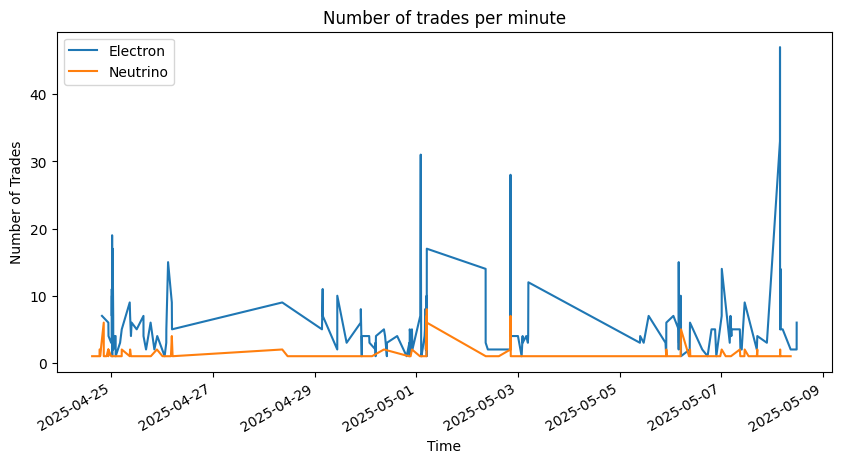

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
fills_df['time'].dt.floor('T').value_counts().sort_index().plot(label='Electron')
fills_df2['time'].dt.floor('T').value_counts().sort_index().plot(label='Neutrino')
plt.legend()
plt.title('Number of trades per minute')
plt.xlabel('Time')
plt.ylabel('Number of Trades')
plt.show()


In [36]:
import pandas as pd

# 確保排序（merge_asof 需要）
df_a = fills_df.sort_values('time').reset_index(drop=True)
df_b = fills_df2.sort_values('time').reset_index(drop=True)

# ---- A 對 B：找出每筆 A 最近的 B（±1秒） ----
matched_from_a = pd.merge_asof(
    df_a, df_b, on='time',
    direction='nearest',
    tolerance=pd.Timedelta('1s'),
    suffixes=('_a', '_b')
)

# 根據 df_b 的某個欄位來判斷 match 成功
# 假設你有 'px' 欄位（成交價格）
a_match_ratio = matched_from_a['px_b'].notna().mean()
print(f"electron txf:202505成交中，有 {a_match_ratio:.2%} 的成交在 ±1 秒內也有neutrino TMF的成交")

# ---- B 對 A：再做一次反向 ----
matched_from_b = pd.merge_asof(
    df_b, df_a, on='time',
    direction='nearest',
    tolerance=pd.Timedelta('1s'),
    suffixes=('_b', '_a')
)

b_match_ratio = matched_from_b['px_a'].notna().mean()
print(f"neutrino tmf:202505成交中，有 {b_match_ratio:.2%} 的成交在 ±1 秒內也有electron txf:202505的成交")


electron txf:202505成交中，有 19.31% 的成交在 ±1 秒內也有neutrino TMF的成交
neutrino tmf:202505成交中，有 33.51% 的成交在 ±1 秒內也有electron txf:202505的成交


In [37]:
fills_df_fire = fills_df[fills_df['alqortake'] == 'take']
fills_df_fire2 = fills_df2[fills_df2['alqortake'] == 'take']

In [38]:
fills_df_fire2

,time,ts,instr,oflag,tid,px,alqortake,sz,theo,fwd,ffwd,edge,roll_offset,label,delta,vega,gamma,theta,vol,mult,latefill,fee,qm,pfdelta,otags,seq
55,2025-04-24 22:35:02.109715,1745505302109715,FUT_TAIFEX_TXF:202505,0,TAIFEX106#556011,19735,take,1,19735.0,19735.0,19735,0,0,gq_hdg,1,0,0,0,0,200,False,0.49470,0,0,0x0,56
72,2025-04-24 22:40:09.175564,1745505609175564,FUT_TAIFEX_TXF:202505,0,TAIFEX106#566361,19749,take,-1,19750.0,19750.0,19750,0,0,gq_hdg,1,0,0,0,0,200,False,0.49498,0,0,0x0,73
140,2025-04-28 08:45:00.086305,1745801100086305,FUT_TAIFEX_TXF:202505,0,TAIFEX106#1,19966,take,1,19965.0,19965.0,19965.0,0,0,,1,0,0,0,0,200,False,0.49932,0,0,0x0,1
143,2025-04-28 08:45:00.093320,1745801100093320,FUT_TAIFEX_TXF:202505,0,TAIFEX106#16,19969,take,1,19967.5,19967.5,19967.5,0,0,gq_hdg,1,0,0,0,0,200,False,0.49938,0,0,0x0,4
226,2025-05-01 04:55:13.629244,1746046513629244,FUT_TAIFEX_TXF:202505,0,TAIFEX106#1129351,20392,take,-1,20394.0,20394.0,20394.0,0,0,gq_hdg,1,0,0,0,0,200,False,0.50784,0,0,0x0,47
229,2025-05-01 04:55:14.040863,1746046514040863,FUT_TAIFEX_TXF:202505,0,TAIFEX106#1129379,20394,take,-1,20395.5,20395.5,20395.5,0,0,,1,0,0,0,0,200,False,0.50788,0,0,0x0,50
232,2025-05-01 04:55:14.043188,1746046514043188,FUT_TAIFEX_TXF:202505,0,TAIFEX106#1129381,20393,take,-1,20394.5,20394.5,20394.5,0,0,,1,0,0,0,0,200,False,0.50786,0,0,0x0,53
235,2025-05-01 04:55:14.045747,1746046514045747,FUT_TAIFEX_TXF:202505,0,TAIFEX106#1129383,20394,take,-1,20395.5,20395.5,20395.5,0,0,,1,0,0,0,0,200,False,0.50788,0,0,0x0,56
245,2025-05-01 04:56:23.432219,1746046583432219,FUT_TAIFEX_TXF:202505,0,TAIFEX106#1130216,20402,take,-1,20401.5,20401.5,20401.5,0,0,,1,0,0,0,0,200,False,0.50804,0,0,0x0,66
251,2025-05-01 04:58:49.690546,1746046729690546,FUT_TAIFEX_TXF:202505,0,TAIFEX106#1132023,20414,take,-1,20415.5,20415.5,20415.5,0,0,,1,0,0,0,0,200,False,0.50828,0,0,0x0,72


In [39]:
import pandas as pd

# 確保排序（merge_asof 需要）
df_a = fills_df.sort_values('time').reset_index(drop=True)
df_b = fills_df2.sort_values('time').reset_index(drop=True)

# ---- A 對 B：找出每筆 A 最近的 B（±1秒） ----
matched_from_a = pd.merge_asof(
    df_a, df_b, on='time',
    direction='nearest',
    tolerance=pd.Timedelta('5s'),
    suffixes=('_a', '_b')
)

# 根據 df_b 的某個欄位來判斷 match 成功
# 假設你有 'px' 欄位（成交價格）
a_match_ratio = matched_from_a['px_b'].notna().mean()
print(f"electron txf:202505成交中，有 {a_match_ratio:.2%} 的成交在 ±5 秒內也有neutrino TMF的成交")

# ---- B 對 A：再做一次反向 ----
matched_from_b = pd.merge_asof(
    df_b, df_a, on='time',
    direction='nearest',
    tolerance=pd.Timedelta('5s'),
    suffixes=('_b', '_a')
)

b_match_ratio = matched_from_b['px_a'].notna().mean()
print(f"neutrino tmf:202505成交中，有 {b_match_ratio:.2%} 的成交在 ±5 秒內也有electron txf:202505的成交")


electron txf:202505成交中，有 24.72% 的成交在 ±5 秒內也有neutrino TMF的成交
neutrino tmf:202505成交中，有 35.08% 的成交在 ±5 秒內也有electron txf:202505的成交


In [40]:
import pandas as pd

def compute_weighted_time_match(fills_df, fills_df2, seconds=1):
    # 確保時間排序
    df_a = fills_df.sort_values('time').reset_index(drop=True)
    df_b = fills_df2.sort_values('time').reset_index(drop=True)
    
    # merge_asof：A 對 B
    matched_from_a = pd.merge_asof(
        df_a, df_b, on='time',
        direction='nearest',
        tolerance=pd.Timedelta(seconds=seconds),
        suffixes=('_a', '_b')
    )
    matched_from_a['weighted'] = matched_from_a.apply(
        lambda row: row['sz_a'] if pd.notna(row['sz_b']) else 0,
        axis=1
    )
    a_weighted_ratio = matched_from_a['weighted'].sum() / matched_from_a['sz_a'].sum()

    # merge_asof：B 對 A
    matched_from_b = pd.merge_asof(
        df_b, df_a, on='time',
        direction='nearest',
        tolerance=pd.Timedelta(seconds=seconds),
        suffixes=('_b', '_a')
    )
    matched_from_b['weighted'] = matched_from_b.apply(
        lambda row: row['sz_b'] if pd.notna(row['sz_a']) else 0,
        axis=1
    )
    b_weighted_ratio = matched_from_b['weighted'].sum() / matched_from_b['sz_b'].sum()

    return a_weighted_ratio, b_weighted_ratio


In [48]:
a_ratio, b_ratio = compute_weighted_time_match(fills_df, fills_df2, seconds=5)

print(f"electron tmf:202505成交時 有 {a_ratio:.2%} 在 ±5 秒內也有 neutrino TXF:202505 的成交")
print(f"neutrino txf:202505成交時 有 {b_ratio:.2%} 在 ±5 秒內也有 electron TMF:202505 的成交")


electron tmf:202505成交時 有 36.96% 在 ±5 秒內也有 neutrino TXF:202505 的成交
neutrino txf:202505成交時 有 77.27% 在 ±5 秒內也有 electron TMF:202505 的成交


In [42]:
fills_df2.shape

(191, 26)

In [47]:
fills_df.shape

(979, 26)